In [0]:
import os
import pandas as pd
import numpy as np
import json
from google.colab import files
import io
from keras import layers
from keras import models
from keras import applications
from keras import optimizers
import keras

Using TensorFlow backend.


In [0]:
from google.colab import drive
drive.mount('/content/drive')

KeyboardInterrupt: ignored

In [0]:
!unzip -q "/content/drive/My Drive/Tadkamadla, Aashrith Sai"

I have checked if the file contains any file ending with **.json** and extracted all the **pose_keypoints_2d** and appended them into a data frame. I have taken only the co-ordinate values and not the probability of prediction from the openpose output.


In [0]:
i=2
path='/content/drive/My Drive/positive samples/video3.json'
#path='/content/13'
json_files=[pos_json for pos_json in os.listdir(path) if pos_json.endswith('.json')]
print('Found: ',len(json_files),'json keypoint frame files')
a=json.load(open(path+'/'+json_files[0]))
b=a['people']
q=b[0]['pose_keypoints_2d']
s=[p for p in q if p>1]
train=pd.DataFrame([s])
for j in range(1,len(json_files)):
    a=json.load(open(path+'/'+json_files[j]))
    b=a['people']
    if len(b)>0:
        q=b[0]['pose_keypoints_2d']
        s=[p for p in q if p>1]
        s=pd.DataFrame([s])
        train=train.append(s,ignore_index=True,sort=False)
    else:
        continue

Found:  3908 json keypoint frame files


The next code is used to clean the data and I have used **method='ffill'** to get the same values as the previous rows if there are NaN values. I have also handled the case where the pose_keypoints_2d are detected to be less than 50 features. I have made them equal to zero as often the keypoints of the toe are not properly detected and my model is not going to get affected by these values. 

In [0]:
train=train.fillna(method='ffill')
train=train.fillna(0)
y,x=train.shape
s=np.zeros(y)
s=pd.DataFrame(s)

for i in range(50):
    y,x=train.shape
    if x!=50:
        train[x]=s
        x=x+1
    if y<90:
        train=train.append(train.iloc[y-1],ignore_index=True,sort=False)

for i in range(50):
    train.iloc[:,i]=train.iloc[:,i]/train.iloc[:,i].max()

In [0]:
train=train.fillna(method='ffill')
train=train.fillna(0)
train

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49
0,0.709859,0.724448,0.659839,0.864325,0.624714,0.659747,0.566257,0.548671,0.598719,0.460813,0.789954,0.783035,0.608083,0.838451,0.457673,0.845093,0.491378,0.800242,0.496841,0.671168,0.292729,0.563930,0.079499,0.599489,0.505866,0.698839,0.329074,0.707865,0.079309,0.715352,0.882192,0.683642,0.897476,0.742714,0.879613,0.856714,0.066875,0.924109,0.025320,0.706044,0.323042,0.732412,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.711736,0.699429,0.659813,0.864258,0.619263,0.668362,0.560340,0.557383,0.598605,0.442344,0.799170,0.782822,0.603672,0.828426,0.451171,0.822828,0.495785,0.800117,0.496861,0.666893,0.299414,0.563935,0.079483,0.599468,0.514909,0.695387,0.329108,0.707766,0.077084,0.718698,0.882169,0.679411,0.895286,0.722176,0.881859,0.839759,0.064597,0.924122,0.025296,0.710259,0.311824,0.724092,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.706211,0.694943,0.659813,0.859771,0.617510,0.676857,0.558424,0.586556,0.596106,0.438580,0.801484,0.772639,0.605811,0.818207,0.449010,0.784971,0.482531,0.809030,0.490172,0.683706,0.299378,0.563926,0.079543,0.599490,0.494561,0.698693,0.324576,0.704572,0.104173,0.712117,0.879943,0.670980,0.890698,0.709792,0.879706,0.827397,0.004944,0.696425,0.330551,0.731340,0.311824,0.724092,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.702557,0.690748,0.661703,0.864284,0.615695,0.702588,0.558341,0.603682,0.596043,0.446025,0.803751,0.762267,0.603687,0.794641,0.459799,0.753375,0.498006,0.808998,0.505803,0.683701,0.310504,0.563895,0.079510,0.599486,0.508114,0.695296,0.313371,0.704521,0.079362,0.715444,0.877679,0.662741,0.883960,0.705524,0.881836,0.822871,0.066929,0.924228,0.025341,0.689287,0.311597,0.728162,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.702432,0.686544,0.661741,0.864271,0.615664,0.711434,0.564285,0.637360,0.596093,0.464562,0.803727,0.755269,0.605881,0.767752,0.457717,0.718482,0.486963,0.809025,0.494629,0.687900,0.308274,0.567284,0.081766,0.599515,0.496847,0.691929,0.322325,0.704469,0.153828,0.721976,0.877594,0.658510,0.883852,0.697350,0.879659,0.818589,0.066929,0.924228,0.025341,0.689287,0.311597,0.728162,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3878,0.715352,0.796485,0.665541,0.868823,0.630140,0.651158,0.560409,0.531945,0.578475,0.460843,0.799107,0.803559,0.623562,0.848508,0.477350,0.797594,0.500220,0.831284,0.508008,0.688074,0.279307,0.563895,0.077282,0.596222,0.514983,0.722687,0.315618,0.711149,0.081575,0.708828,0.891157,0.750333,0.899766,0.813614,0.888675,0.721832,0.894588,0.890498,0.031115,0.718673,0.323173,0.724106,0.459747,0.76577,0.583072,0.930108,0.547859,0.972056,0.659989,0.999983
3879,0.715421,0.792523,0.665502,0.868755,0.628313,0.655333,0.560424,0.531941,0.583497,0.430979,0.801421,0.803565,0.614719,0.845139,0.477332,0.772192,0.498018,0.822380,0.505793,0.683748,0.285977,0.563859,0.079517,0.596212,0.514934,0.709044,0.320078,0.707796,0.079315,0.712125,0.893405,0.750043,0.899913,0.813464,0.884175,0.717522,0.901451,0.890439,0.272043,0.882370,0.334573,0.765815,0.459740,0.77016,0.583072,0.930108,0.547859,0.972056,0.659989,0.999983
3880,0.715421,0.792529,0.663703,0.855333,0.626486,0.668115,0.566260,0.548814,0.588576,0.412342,0.803743,0.789853,0.619114,0.825093,0.479483,0.724969,0.484749,0.831062,0.496844,0.687943,0.297143,0.563956,0.081789,0.596194,0.496771,0.705642,0.313337,0.704537,0.081653,0.712062,0.891149,0.745847,0.899874,0.813283,0.881906,0.700786,0.901436,0.886230,0.025309,0.697693,0.357529,0.732417,0.459740,0.77016,0.583072,0.930108,0.547859,0.972056,0.659989,0.999983
3881,0.715402,0.779661,0.665508,0.8642

I have given one output for 90 frames and hence always taken the input data as multiples of 90.

Loading the data and Reshaping the values as **(Samples,Timesteps,Features)** using numpys reshape method

In [0]:
finalx=pd.read_csv('../content/DATA.csv')
finaly=np.loadtxt('../content/Y', delimiter=',')
valx=pd.read_csv('../content/valx.csv')
valy=np.loadtxt('../content/valy', delimiter=',')

In [0]:
finalx

,Unnamed: 0,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
0,0,0.767043,0.935773,0.983416,0.807895,0.767855,0.950719,0.821064,0.927059,0.987307,0.939957,0.804025,0.913907,0.810659,0.922904,0.992343,0.707378,0.966012,0.904082,0.777627,0.944541,0.803255,0.897625,0.996503,0.692278,0.659681,0.782173,0.866359,0.837813,0.987835,0.965068
1,1,0.762597,0.985161,0.979153,0.841979,0.761379,0.991724,0.813179,0.953896,0.982161,0.969826,0.790836,0.969284,0.805353,0.968146,0.984599,0.747551,0.952943,0.926791,0.769157,0.974441,0.769589,0.913945,0.982616,0.962071,0.650792,0.813789,0.814319,0.807167,0.980912,0.991205
2,2,0.758326,0.970430,0.908750,0.833521,0.709744,0.979551,0.771157,0.942496,0.936303,0.999896,0.721071,0.950872,0.752742,0.942396,0.930687,0.692110,0.903183,0.908698,0.733178,0.961527,0.723488,0.934377,0.595610,0.730125,0.820970,0.763870,0.947930,0.715133,0.296990,0.891006
3,3,0.864259,0.935728,0.975024,0.803443,0.761393,0.946534,0.807948,0.927021,0.971964,0.977382,0.780787,0.901542,0.789620,0.890511,0.966640,0.661671,0.945075,0.894924,0.769121,0.936058,0.753618,0.913935,0.979161,0.696550,0.643680,0.772949,0.817751,0.745780,0.972238,0.720791
4,4,0.788071,0.965622,0.937775,0.824868,0.735770,0.975372,0.794718,0.934836,0.959254,0.984927,0.740980,0.926161,0.765915,0.909975,0.940980,0.661986,0.931979,0.890455,0.756442,0.935929,0.815655,0.840265,0.954860,0.940940,0.629533,0.763895,0.809082,0.846567,0.953138,0.978137
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117145,117145,0.306659,0.441348,0.397861,0.539495,0.381109,0.600015,0.501029,0.647216,0.608714,0.668660,0.383624,0.383792,0.519970,0.371469,0.478239,0.432298,0.561425,0.534200,0.557879,0.592852,0.645805,0.589213,0.773530,0.624817,0.539240,0.457720,0.654854,0.444051,0.863700,0.405669
117146,117146,0.306613,0.460517,0.399777,0.554427,0.388545,0.602903,0.504858,0.658263,0.608702,0.684931,0.383637,0.389366,0.518074,0.374691,0.478243,0.459466,0.559649,0.548265,0.550792,0.604120,0.647478,0.597338,0.773530,0.619294,0.537544,0.460526,0.693955,0.435822,0.867091,0.405696
117147,117147,0.312864,0.487806,0.399803,0.566474,0.396018,0.622013,0.504858,0.658499,0.608712,0.690449,0.381783,0.405816,0.516192,0.392419,0.483692,0.480677,0.572061,0.556717,0.566777,0.612532,0.659410,0.602855,0.771794,0.619270,0.542645,0.474168,0.627658,0.449606,0.702119,0.438591
117148,117148,0.314970,0.512431,0.401766,0.572573,0.396100,0.619335,0.495478,0.661230,0.608741,0.706821,0.383580,0.424869,0.512476,0.398631,0.481871,0.519984,0.572066,0.553951,0.568519,0.615306,0.644104,0.611101,0.765018,0.619228,0.547749,0.476914,0.619161,0.463186,0.246000,0.534449


In [0]:
finalx=finalx.iloc[:117135,1:]
finaly=finaly[:117135]

In [0]:

finalx=finalx.fillna(method='ffill')
valx=valx.fillna(method='ffill')

In [0]:
x,y=finalx.shape
#a=finalx.iloc[::2,:]


In [0]:
#sam=a.values
sam=finalx.values

In [0]:
out=pd.DataFrame(finaly)

In [0]:
#out=out.iloc[::2,:]

In [0]:
out=out.values

In [0]:
out.shape

(117135, 1)

In [0]:
sam.shape

(117135, 30)

In [0]:
#finalx=trainx.iloc[:len(finaly),:]
X=sam
X=X.reshape(int(len(out)/45),45,30)
#Y=np.array(finaly)
#Y=Y.reshape(len(finaly),1)

In [0]:
Y=out
Y=Y.reshape(int(len(out)/45),45,1)


In [0]:
x=valx.values
x=x.reshape(int(len(valy)/45),45,30)

In [0]:
y=valy
y=y.reshape(int(len(valy)/45),45,1)

In [0]:
X.shape

(2603, 45, 30)

I have used callbacks for **model checkpointing** and **early stopping**

In [0]:
from keras.callbacks import EarlyStopping
from keras import regularizers
import tensorflow as tf
from keras.callbacks import ModelCheckpoint
checkpoint_path='/content/weights.{epoch:02d}-{val_loss:.2f}.hdf5'
callbacks_list=tf.keras.callbacks.ModelCheckpoint(checkpoint_path,save_weights_only=False,save_best_only=True,monitor='loss')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=5)

**Model Architecture**

In [0]:
from keras.layers import Input, Dense, LSTM, MaxPooling1D, Conv1D,Dropout,BatchNormalization,TimeDistributed
from keras.models import Model
import tensorflow as tf
from keras import layers

input_layer = Input(shape=(45,30))
conv1 = Conv1D(filters=45,kernel_size=5,strides=1,activation='relu',padding='same')(input_layer)
lstm1 = LSTM(45,return_sequences=True)(conv1)
drop1=Dropout(0.2)(lstm1)
lstm2 = LSTM(45,return_sequences=True)(drop1)
drop2=Dropout(0.2)(lstm2)
hidden1=TimeDistributed(Dense(90,activation='relu'))(drop2)
batch1=BatchNormalization()(hidden1)
drop3=TimeDistributed(Dropout(0.2))(batch1)

input_layer2=Input(shape=(45,30))
lstm3=LSTM(45,return_sequences=True)(input_layer2)
drop4=Dropout(0.2)(lstm3)
lstm4=LSTM(45,return_sequences=True)(drop4)
drop5=Dropout(0.2)(lstm4)
hidden2=TimeDistributed(Dense(90,activation='relu'))(drop5)
batch=BatchNormalization()(hidden2)
drop6=TimeDistributed(Dropout(0.2))(batch)

concat=layers.concatenate([drop3,drop6],axis=-1)
#lstm5=LSTM(45,return_sequences=True)(concat)
#final=Dense(45,activation='relu')(lstm5)
out=Dense(1,activation='sigmoid')(concat)

model = Model(inputs=[input_layer,input_layer2], outputs=out) 

I have used Adam optimizer and have manually checked the learning rate and selected 0.0001 as the best fit.

In [0]:

adam=tf.keras.optimizers.Adam(lr=0.00002, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [0]:
X_train=tf.convert_to_tensor(X, np.float32)
X_test=tf.convert_to_tensor(x, np.float32)
y_train=tf.convert_to_tensor(Y)
y_test=tf.convert_to_tensor(y, np.float32)

In [0]:
X_train.shape

TensorShape([2603, 45, 30])

In [0]:
sw=[]
for i in range(2603):
    if finaly[i*45:(i+1)*45].all()==1:
        sw.append(50)
    else:
        sw.append(1)
sw=np.array(sw)

In [0]:
#sw=sw.reshape(int(len(finaly)/45),45,1)

In [0]:
sw.shape

(2603,)

Training the model to 500 epochs using the batch size of 5

In [54]:
class_weights = {0: 1.,1: 2.}
history=model.fit([X_train, X_train],y_train,epochs=500,steps_per_epoch=20,validation_data=([x,x],y),validation_steps=1,callbacks=[es])

Train on 2603 samples, validate on 400 samples
Epoch 1/500
20/20 [==============================] - 84s 4s/step - loss: 0.3289 - accuracy: 0.8161 - val_loss: 0.6838 - val_accuracy: 0.6957
Epoch 2/500
20/20 [==============================] - 84s 4s/step - loss: 0.2499 - accuracy: 0.8554 - val_loss: 0.7722 - val_accuracy: 0.6949
Epoch 3/500
20/20 [==============================] - 85s 4s/step - loss: 0.2219 - accuracy: 0.8726 - val_loss: 0.8318 - val_accuracy: 0.7208
Epoch 4/500
20/20 [==============================] - 83s 4s/step - loss: 0.2107 - accuracy: 0.8785 - val_loss: 0.9017 - val_accuracy: 0.7348
Epoch 5/500
20/20 [==============================] - 84s 4s/step - loss: 0.2048 - accuracy: 0.8816 - val_loss: 0.9252 - val_accuracy: 0.7343
Epoch 6/500
20/20 [==============================] - 84s 4s/step - loss: 0.2009 - accuracy: 0.8838 - val_loss: 0.9783 - val_accuracy: 0.7388
Epoch 00006: early stopping


In [0]:
from sklearn.metrics import confusion_matrix
y_pred=model.predict([x,x])


In [0]:
l=y_pred.flatten()
q=[]
for i in l:
    if i>=0.5:
        q.append(1)
    else:
        q.append(0)


In [0]:
q=np.array(q)

In [0]:
len(q)

18000

In [0]:
tn, fp, fn, tp = confusion_matrix(valy, q).ravel()
print(tn,tp,fn,fp)

11202 2886 2964 948


In [0]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 45, 30)       0                                            
__________________________________________________________________________________________________
conv1d_3 (Conv1D)               (None, 45, 45)       6795        input_5[0][0]                    
__________________________________________________________________________________________________
input_6 (InputLayer)            (None, 45, 30)       0                                            
__________________________________________________________________________________________________
lstm_10 (LSTM)                  (None, 45, 45)       16380       conv1d_3[0][0]                   
____________________________________________________________________________________________

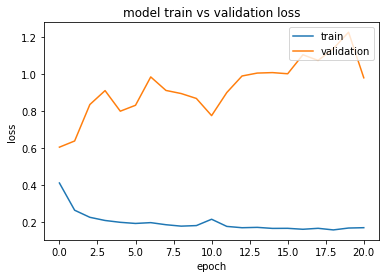

In [0]:
import matplotlib.pyplot as pyplot
pyplot.plot(history.history['loss'])
pyplot.plot(history.history['val_loss'])
pyplot.title('model train vs validation loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper right')
pyplot.show()

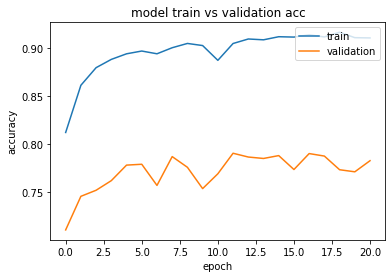

In [0]:
pyplot.plot(history.history['accuracy'])
pyplot.plot(history.history['val_accuracy'])
pyplot.title('model train vs validation acc')
pyplot.ylabel('accuracy')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper right')
pyplot.show()

In [0]:
model.save('../content/wts.h5')

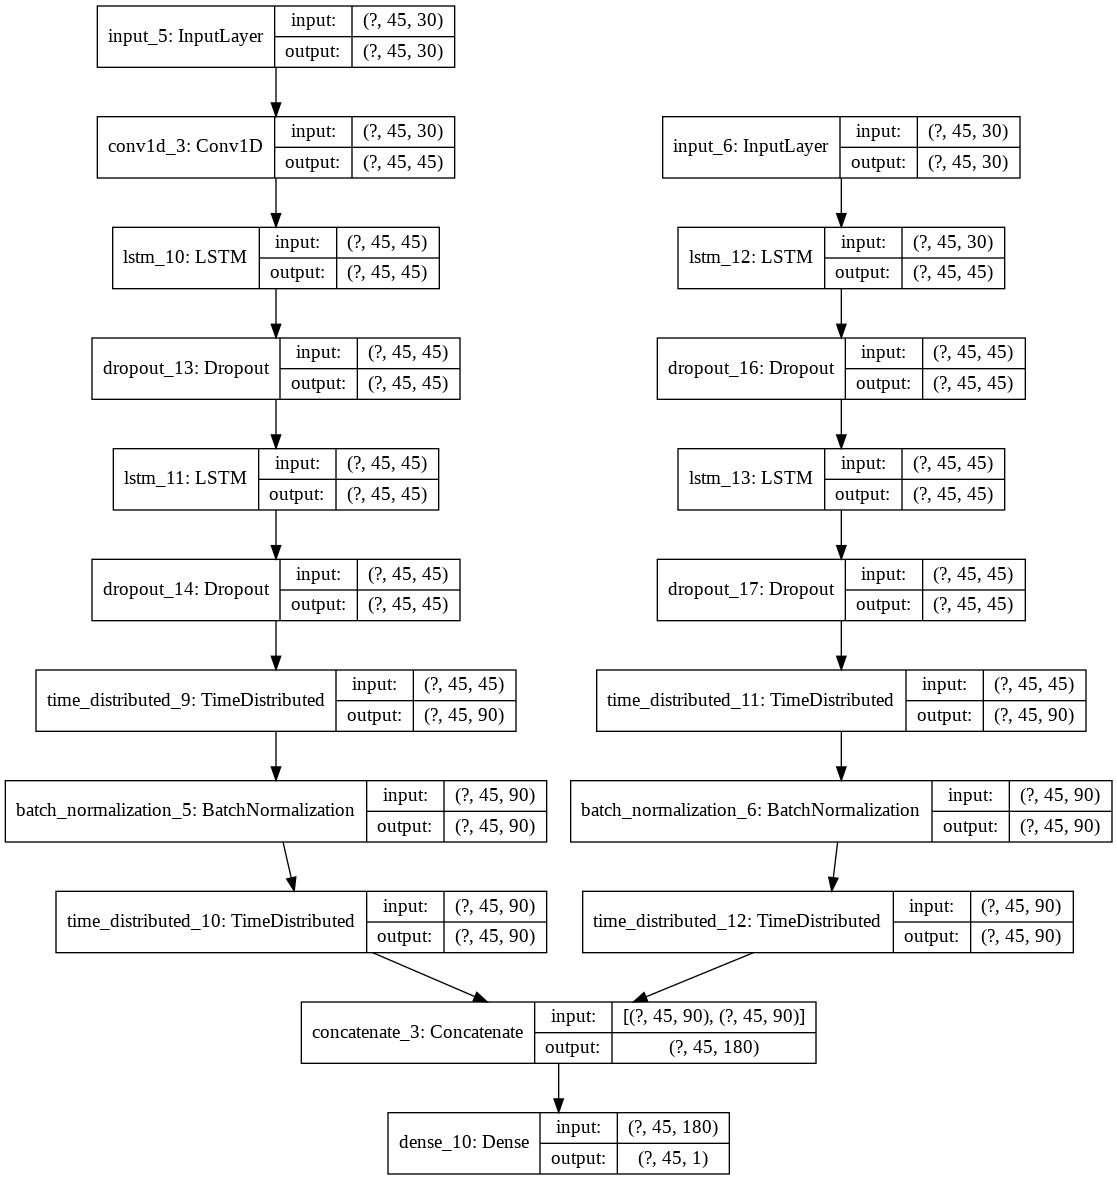

In [0]:

from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [0]:
input_layer = Input(shape=(45,30))
conv1 = Conv1D(filters=45,kernel_size=5,strides=1,activation='relu',padding='same')(input_layer)
lstm1 = LSTM(45,return_sequences=True)(conv1)
#drop1=Dropout(0.2)(lstm1)
lstm2 = LSTM(45,return_sequences=True)(lstm1)
#drop2=Dropout(0.2)(lstm2)
hidden1=Dense(90,activation='relu')(lstm2)
batch1=BatchNormalization()(hidden1)
drop3=Dropout(0.2)(batch1)

input_layer2=Input(shape=(45,30))
lstm3=LSTM(45,return_sequences=True)(input_layer2)
#drop4=Dropout(0.2)(lstm3)
lstm4=LSTM(45,return_sequences=True)(lstm3)
drop5=Dropout(0.2)(lstm4)
hidden2=Dense(90,activation='relu')(drop5)
batch=BatchNormalization()(hidden2)
drop6=Dropout(0.2)(batch)

concat=layers.concatenate([drop3,drop6],axis=-1)
final=Dense(45,activation='relu')(concat)
out=Dense(1,activation='sigmoid')(final)

model = Model(inputs=[input_layer,input_layer2], outputs=out) 

In [0]:
from keras.models import load_model
model=tf.keras.models.load_model('../content/wtsconvlstm.h5')